# Example notebook 1: pipeline walkthrough

This notebook walks through the process of generating a Roman WFI image of a strong lens starting with its parameterization in `lenstronomy`.

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from hydra import initialize, compose
import astropy.cosmology as astropy_cosmo
from pyHalo.preset_models import CDM
from pprint import pprint

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

# enable use of local modules
repo_dir  = config.machine.repo_dir
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

from mejiro.lenses.strong_lens import StrongLens
from mejiro.plots import plot
from mejiro.helpers import pyhalo, pandeia_input

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

# Set up a strong lens in `lenstronomy`

Below is a sample strong lens in `lenstronomy` format, based upon a strong lens from our Roman HLWAS survey simulation.

The minimum requirements to generate an image with this pipeline are:
* `kwargs_params`
* `kwargs_model`
    * While the redshift-related attributes are not always required to generate an image in `lenstronomy`, they are required for this pipeline (e.g. `pyHalo` generates redshift-dependent subhalo populations).
    * The `cosmo` attribute should be set to `astropy_cosmo.default_cosmology.get()` which provides Plank18 cosmology. This is the cosmology used in other parts of the pipeline and this value is not passed through, so to be in agreement with the rest of the pipeline (both upstream in the `SkyPy`/`SLSim` survey simulation and downstream by `pyHalo`), this value should stay constant. This may be addressed in a future update.

In [2]:
band = 'F106'
z_lens = 0.5
z_source = 2.

lens_mags = {
  'f106': 20.47734355,
  'f129': 20.1486012,
  'f158': 19.94610498,
  'f184': 19.85683648
}
source_mags = {
  'f106': 22.18633408,
  'f129': 21.98034088,
  'f158': 21.77380172,
  'f184': 21.649701
}

kwargs_lens = [{'center_x': 0.1,
  'center_y': -0.1,
  'e1': 0.01,
  'e2': 0.02,
  'gamma': 2,
  'theta_E': 0.8},
 {'dec_0': 0,
  'gamma1': -0.02,
  'gamma2': 0.005,
  'ra_0': 0},
 {'dec_0': 0, 'kappa': -0.036, 'ra_0': 0}]

kwargs_lens_light = [{'R_sersic': 0.38,
  'center_x': 0.1,
  'center_y': -0.1,
  'e1': 0.03,
  'e2': 0.05,
  'n_sersic': 1.0}]

kwargs_source = [{'R_sersic': 0.16,
  'center_x': -0.02,
  'center_y': 0.04,
  'e1': -0.39,
  'e2': -0.12,
  'n_sersic': 1.0}]

kwargs_params = {
    'kwargs_lens': kwargs_lens,
    'kwargs_lens_light': kwargs_lens_light,
    'kwargs_source': kwargs_source
}

kwargs_model = {
    'cosmo': astropy_cosmo.default_cosmology.get(),
 'lens_light_model_list': ['SERSIC_ELLIPSE'],
 'lens_model_list': ['EPL', 'SHEAR', 'CONVERGENCE'],
 'lens_redshift_list': [z_lens] * 3,
 'source_light_model_list': ['SERSIC_ELLIPSE'],
 'source_redshift_list': [z_source],
 'z_source': z_source,
 'z_source_convention': 5.}

The object below is simply a way to keep track of this strong lens, with associated attributes and methods.

In [3]:
strong_lens = StrongLens(kwargs_model=kwargs_model, kwargs_params=kwargs_params, lens_mags=lens_mags, source_mags=source_mags)

# Add subhalos with `pyhalo`

First, generate a population of CDM subhalos.

Note that `pyHalo` supports a broad range of dark matter models (see its [example notebooks](https://github.com/dangilman/pyHalo/tree/master/example_notebooks)). For instance, once could replace the line below with the `WDM` class to generate a population of warm dark matter subhalos.

In [4]:
realizationCDM = CDM(z_lens, z_source, cone_opening_angle_arcsec=6.,
                         LOS_normalization=0., log_mlow=6., log_mhigh=10.)

`pyHalo` has nice plotting routines to easily visualize the properties of this unique subhalo population - [from `pyHalo`'s "Basic usage" Jupyter notebook](https://github.com/dangilman/pyHalo/blob/master/example_notebooks/basic_usage.ipynb):

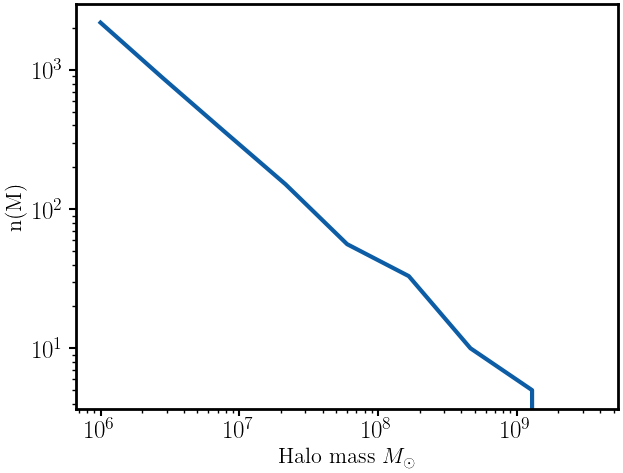

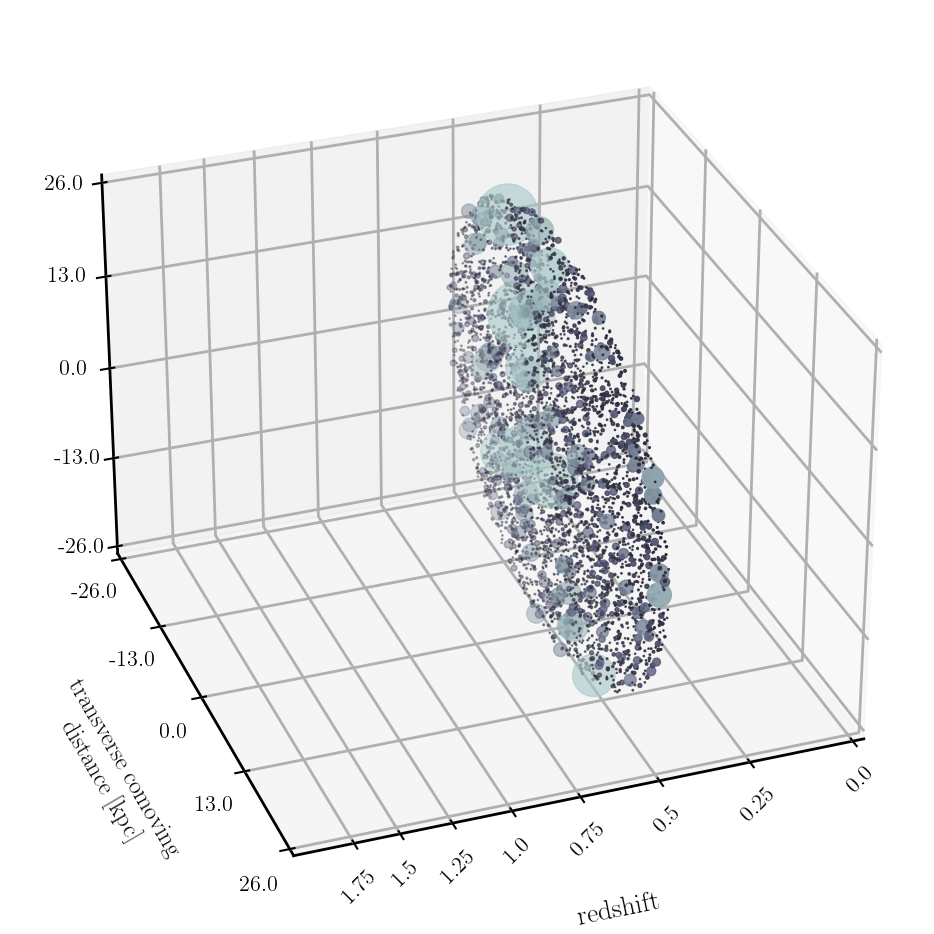

In [5]:
cdm_halo_masses = [halo.mass for halo in realizationCDM.halos]
N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.loglog(m[0:-1], N)
ax.set_xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
ax.set_ylabel('n(M)', fontsize=16)

fig = plt.figure(figsize=(14, 12))
ax = plt.subplot(111, projection='3d')
realizationCDM.plot(ax)

Add this subhalo population to the strong lens model:

In [6]:
strong_lens.add_subhalos(*pyhalo.realization_to_lensing_quantities(realizationCDM))

# Produce the synthetic image with `lenstronomy`

This "synthetic image" has no PSF convolution or noise. An arbitrarily upsampled version can be rendered to create a more detailed input to Pandeia.

Note that we will ultimately produce a 45x45 pixel (or 4.95"x4.95") image but here we render an image that's 51x51 pixels (or 5.61"x5.61"). Inputting a larger scene than what Pandeia will output, with a 3 pixel (or 0.33") buffer around the entire image, ensures any flux on the edges of the scene are rendered correctly in the final image.

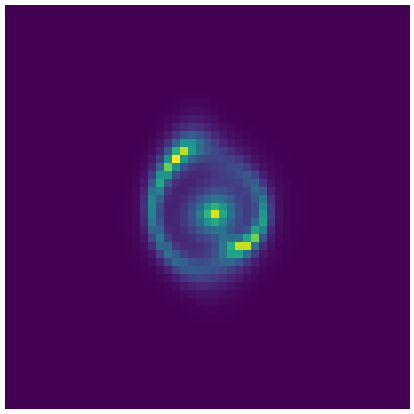

In [7]:
model = strong_lens.get_array(num_pix=51, side=5.61, band='f106')

plt.imshow(model)
plt.axis('off')
plt.show()

# Run this synthetic lens through Pandeia

Generate the input .json file for the Pandeia engine.

The following code translates the surface brightness array from `lenstronomy` above into point sources that the Pandeia engine can handle as input. The array is interpreted as a PSF and `num_sample` samples are taken from it, then a point source of an appropriate brightness (corresponding to the number of samples for that location) is placed there.

Note that the estimated calculation time is a simplistic polynomial fit based on an earlier version of the code, so can be somewhat inaccurate depending on the input and configuration options.

In [8]:
calc, num_point_sources = pandeia_input.build_pandeia_calc(model, 
                                                           strong_lens, 
                                                           background=True, 
                                                           band='f106', 
                                                           max_scene_size=5, 
                                                           noise=True, 
                                                           num_samples=10000,
                                                           suppress_output=False)

  0%|          | 0/526 [00:00<?, ?it/s]

100%|██████████| 526/526 [00:03<00:00, 147.72it/s]


Point source conversion complete: placed 526 point sources
Estimated calculation time: 0:00:41


A few choices are being made behinds the scenes in the code above, so we expose them here. We set the detector parameters based on the proposed HLWAS.

In [9]:
pprint(calc['configuration']['instrument'])

{'aperture': 'imaging',
 'disperser': None,
 'filter': 'f106',
 'instrument': 'wfi',
 'mode': 'imaging'}


In [10]:
pprint(calc['configuration']['detector'])

{'ma_table_name': 'hlwas_imaging',
 'nexp': 1,
 'ngroup': 10,
 'nint': 1,
 'readout_pattern': 'deep2',
 'subarray': 'imaging'}


All noise sources and effects that are applicable to Roman WFI imaging are enabled.

In [11]:
pprint(calc['calculation'])

{'effects': {'saturation': True},
 'noise': {'crs': True,
           'dark': True,
           'excess': False,
           'ffnoise': True,
           'readnoise': True,
           'scatter': False}}


Finally, we can generate the image with Pandeia.

In [12]:
image, execution_time = pandeia_input.get_pandeia_image(calc, suppress_output=False)

Performing Pandeia calculation...
Pandeia calculation complete in 0:00:48


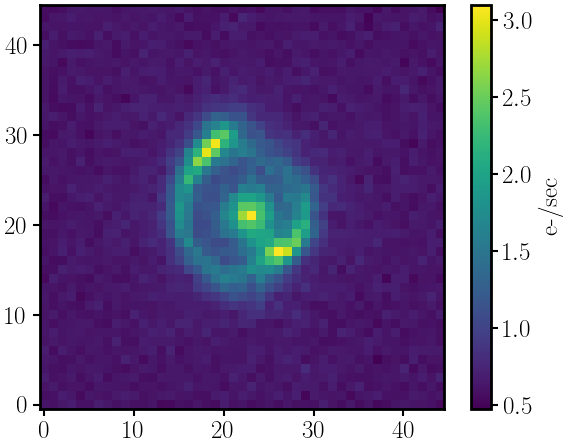

In [13]:
plot.plot(image, colorbar=True, colorbar_label='e-/sec')